In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import Model
from keras import layers
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.python.keras.layers import Dropout, Flatten
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.python.keras import initializers
import os, shutil
from os import listdir, path, makedirs
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
from shutil import copyfile
import seaborn as sns
import numpy as np
np.random.seed(0)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ReLMPYgrLXAPhAlo2pd4atv2TZa0fvjM' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1ReLMPYgrLXAPhAlo2pd4atv2TZa0fvjM" -O data.zip && rm -rf /tmp/cookies.txt

--2020-05-16 20:19:16--  https://docs.google.com/uc?export=download&confirm=yiJV&id=1ReLMPYgrLXAPhAlo2pd4atv2TZa0fvjM
Resolving docs.google.com (docs.google.com)... 108.177.126.139, 108.177.126.138, 108.177.126.113, ...
Connecting to docs.google.com (docs.google.com)|108.177.126.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-0s-docs.googleusercontent.com/docs/securesc/hi11ebncmfp9e2c84uepoe7696aa7a9q/5a9k72bqc378tulq07m788l6m3bir7t0/1589660325000/14211000813324722452/11405224629187835816Z/1ReLMPYgrLXAPhAlo2pd4atv2TZa0fvjM?e=download [following]
--2020-05-16 20:19:17--  https://doc-0s-0s-docs.googleusercontent.com/docs/securesc/hi11ebncmfp9e2c84uepoe7696aa7a9q/5a9k72bqc378tulq07m788l6m3bir7t0/1589660325000/14211000813324722452/11405224629187835816Z/1ReLMPYgrLXAPhAlo2pd4atv2TZa0fvjM?e=download
Resolving doc-0s-0s-docs.googleusercontent.com (doc-0s-0s-docs.googleusercontent.com)... 74.125.143.132, 2a00:1450:4013:c03::84
Connec

In [0]:
!unzip '/content/data.zip'

Streaming output truncated to the last 5000 lines.
  inflating: split_dataset/train/bottles/img (677).jpg  
  inflating: split_dataset/train/bottles/img (678).jpg  
  inflating: split_dataset/train/bottles/img (679).jpg  
  inflating: split_dataset/train/bottles/img (68).jpg  
  inflating: split_dataset/train/bottles/img (680).jpg  
  inflating: split_dataset/train/bottles/img (681).jpg  
  inflating: split_dataset/train/bottles/img (682).jpg  
  inflating: split_dataset/train/bottles/img (683).jpg  
  inflating: split_dataset/train/bottles/img (684).jpg  
  inflating: split_dataset/train/bottles/img (685).jpg  
  inflating: split_dataset/train/bottles/img (686).jpg  
  inflating: split_dataset/train/bottles/img (687).jpg  
  inflating: split_dataset/train/bottles/img (688).jpg  
  inflating: split_dataset/train/bottles/img (689).jpg  
  inflating: split_dataset/train/bottles/img (69).jpg  
  inflating: split_dataset/train/bottles/img (690).jpg  
  inflating: split_dataset/train/bottle

In [0]:
base_path = '/content/split_dataset'
train_dir = os.path.join(base_path, 'train')
validation_dir = os.path.join(base_path, 'validation')

# **IMAGE PREPROCESSING (DATA AUG)**

In [0]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen =ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    rescale = 1./255,
    fill_mode = 'nearest')

validation_datagen =ImageDataGenerator(rescale = 1./255)

from keras.preprocessing.image import ImageDataGenerator

training_set = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')

validation_set = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')

Found 6481 images belonging to 8 classes.
Found 1625 images belonging to 8 classes.


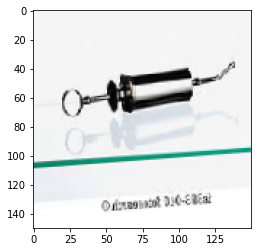

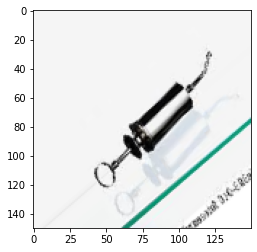

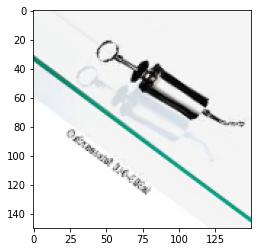

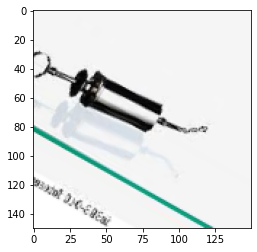

In [0]:
# This is module with image preprocessing utilities
from keras.preprocessing import image

fnames = [os.path.join(train_dir, 'syringes', fname) for fname in os.listdir(os.path.join(train_dir, 'bottles'))]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (227, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

i = 0
for batch in train_datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
plt.show()

In [0]:
def custom_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu',
                          input_shape=(150, 150, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dropout(0.5))
  model.add(Dense(512, activation='relu'))
  model.add(Dense(8, activation='softmax'))

  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['acc'])
  return model

In [0]:
cmodel = custom_model()
print(cmodel.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

In [0]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (32, 150, 150, 3)
labels batch shape: (32, 8)


In [0]:
c_hist = cmodel.fit_generator(
  training_set,
  validation_data=validation_set,
  epochs=50,
  verbose = 1,
  steps_per_epoch=len(training_set),
  validation_steps=len(validation_set)
)

Epoch 1/50
 33/203 [===>..........................] - ETA: 42s - loss: 0.6283 - acc: 0.7727

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


203/203 [==============================] - 62s 308ms/step - loss: 0.6789 - acc: 0.7641 - val_loss: 0.5878 - val_acc: 0.8012
Epoch 2/50
203/203 [==============================] - 62s 308ms/step - loss: 0.6000 - acc: 0.7939 - val_loss: 0.6567 - val_acc: 0.8098
Epoch 3/50
203/203 [==============================] - 62s 305ms/step - loss: 0.5702 - acc: 0.8118 - val_loss: 0.5073 - val_acc: 0.8289
Epoch 4/50
203/203 [==============================] - 63s 311ms/step - loss: 0.5297 - acc: 0.8239 - val_loss: 0.4840 - val_acc: 0.8511
Epoch 5/50
203/203 [==============================] - 62s 306ms/step - loss: 0.5325 - acc: 0.8243 - val_loss: 0.5381 - val_acc: 0.8332
Epoch 6/50
203/203 [==============================] - 62s 307ms/step - loss: 0.4981 - acc: 0.8320 - val_loss: 0.5182 - val_acc: 0.8351
Epoch 7/50
203/203 [==============================] - 63s 308ms/step - loss: 0.4641 - acc: 0.8420 - val_loss: 0.5293 - val_acc: 0.8406
Epoch 8/50
203/203 [==============================] - 62s 308ms/st

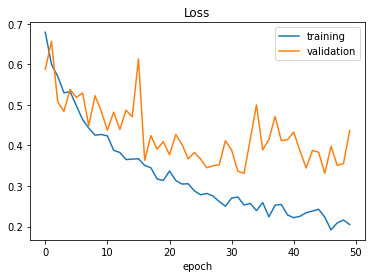

In [0]:
plt.plot(c_hist.history['loss'])
plt.plot(c_hist.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])

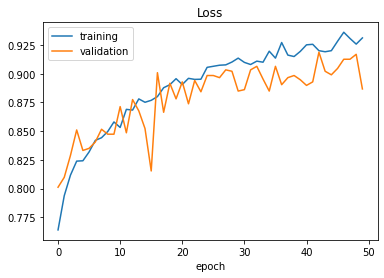

In [0]:
plt.plot(c_hist.history['acc'])
plt.plot(c_hist.history['val_acc'])
plt.title('Loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])

In [0]:
cmodel.save('cmodel.h5')
from google.colab import files
files.download('cmodel.h5')